# Fall 2025 Final Laboratory Exam - Pump Curve

Scoring Guidance

## 1. Time-to-Fill

- Report sample volume used **(10 pts)**
- Record time-to-fill for 5 different outlet elevations.

### Expected Results

**(10 pts)**
|Volume|Time Range(seconds)|Computed Q(LPM)|Computed Q(LPS)|Computed Q(CMS)|
|-----:|------------------:|--------------:|--------------:|--------------:|
|80-100mL|3-6|1-2|0.016-0.032|0.0000167-0.000032|
|200mL   |6-12|1-2|0.016-0.032|0.0000167-0.000032|



## 2. Outlet Elevations ($z_2 - z_1$) (10 pts)

- 5 different elevations
- Must report units
- Readings should be in range 10 - 80 cm.  (100 - 800 mm.) (4 - 32 inches.)  **If used inches check bernoullis for conversions**
  

## 3. Hydraulics 

### Bernoulli's analyzed to find $h_p$ (system equation) (10 pts)

$$ h_p(Q) = (z_2 - z_1) + (1+f\frac{L}{D})              \frac{16 Q^2}{\pi^2 g D^5}$$

```python
def added_head(dz, L, D, ff, Q, g):
    """Pump total dynamic head added."""
    temp1 = (1.0 + ff * L / D)
    temp2 = 16.0 / ((math.pi ** 2) * (D ** 4) * 2.0 * g)
    return dz + temp1 * temp2 * Q ** 2
```

### Reynolds' Number: (10 pts)

$$Re_D(Q)=\frac{4 \rho Q  }{\mu \pi D}$$

```python
def reynolds(Q, D, nu):
    """Reynolds number for circular conduit.
    Q in m^3/s.
    """
    return 4.0 * Q / (math.pi * nu * D)
```

### Friction factor: (10 pts)

The friction factor can be approximated using:

$$f = \frac{0.25}{[log_{10}(\frac{\frac{k_s}{D}}{3.7}+\frac{5.74}{Re_d^{0.9}})]^2}$$

```python
def fricf(ks, Re, D):
    """Jain friction factor."""
    temp1 = ks / (3.7 * D)
    temp2 = 5.74 / (Re ** 0.9)
    temp3 = (math.log10(temp1 + temp2)) ** 2
    return 0.25 / temp3
```

### Roughness height $k_s$ (10 pts)

The roughness height is found using [Roughness Height Database](http://54.243.252.9/toolbox/Databases/RoughnessHeight/RoughnessHeight.html) or other suitable literature reference.

## 4. Data Collected (5 pts for the table)

- Beaker volume: 200 mL
- Collect and average 3 times for each flowrate

|Time (sec)|Q (LPS)|DH (z2-z1)|V(V)|I(A)|P(W)|
|---:|-----:|---:|--:|---:|---:|
|30.3|0.0066|0.78|5.5|0.17|0.935|
|19.6|0.0102|0.76|5.5|0.13|0.715|
|19.0|0.0105|0.46|5.5|0.12|0.660|
|16.8|0.0119|0.37|5.5|0.13|0.715|
|16.4|0.0122|0.30|5.5|0.13|0.715|
|15.9|0.0126|0.23|5.5|0.11|0.575|

## 5. Data Analysis

The script in the appendix takes the table above (as .csv file) and:
1. Ingests the file as shown (the time-to-fill is not supplied in the csv file).
2. Converts Q(LPS) into Q(CMS) for each row
3. Computes: $Re_D(Q)=\frac{4 \rho Q  }{\mu \pi D}$ for each row
4. Computes: $f = \frac{0.25}{[log_{10}(\frac{\frac{k_s}{D}}{3.7}+\frac{5.74}{Re_d^{0.9}})]^2}$ for each row
5. Computes: $ h_p(Q) = (z_2 - z_1) + (1+f\frac{L}{D})\frac{8 Q^2}{\pi^2 g D^4}$ for each row
6. Exports an updated file with $h_p(Q)$ appended as the rightmost column. **(5 pts)** for the TDH column

|Q (LPS)|  DH (z2-z1)  |V(V)  |I(A)  |P(W)  |TDH (m)|
|------:|------:|------:|------:|-------:|--------:|
|0.0066|0.78|5.5|0.17|0.935|0.81|
|0.0102|0.56|5.5|0.13|0.715|0.62|
|0.0105|0.46|5.5|0.12|0.66|0.53|
|0.0119|0.37|5.5|0.13|0.715|0.45|
|0.0122|0.3|5.5|0.13|0.715|0.39|
|0.0126|0.23|5.5|0.11|0.606|0.32|

7. Plots $h_p(Q) versus Q$.
   - **(20 pts)** Must show data and fitted model, must show fitted equation. Not necessarily same equation.  

Fitted model: TDH = 0.888 - 317137.720·Q^3.032


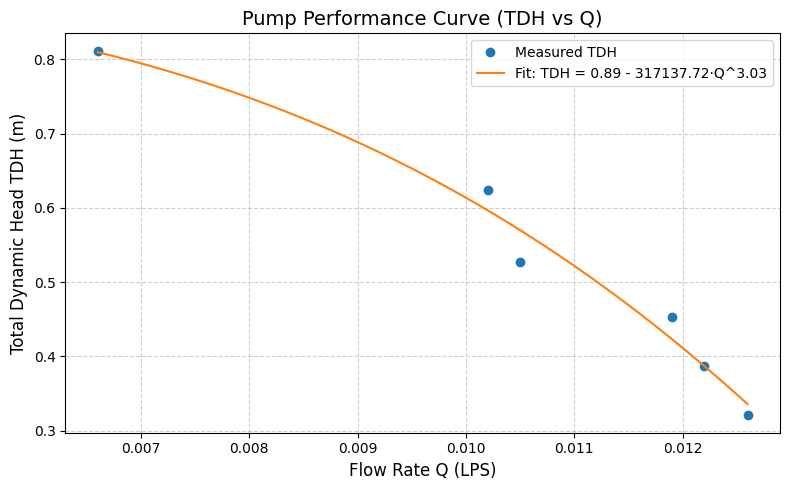

 Q (LPS)  DH (z2-z1)  V(V)  I(A)  P(W)  TDH (m)
  0.0066        0.78   5.5  0.17 0.935 0.810723
  0.0102        0.56   5.5  0.13 0.715 0.623841
  0.0105        0.46   5.5  0.12 0.660 0.527063
  0.0119        0.37   5.5  0.13 0.715 0.453005
  0.0122        0.30   5.5  0.13 0.715 0.386614


In [1]:
import math
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.optimize import curve_fit   # pip install scipy if needed


# --------- CONSTANTS (edit as needed) ---------
KS  = 7.0e-6     # pipe roughness [m] (your table lookup)
NU  = 1.06e-6    # kinematic viscosity [m^2/s]
D   = 0.006      # pipe diameter [m]
L   = 1.0        # pipe length [m]
G   = 9.81       # gravity [m/s^2]


# --------- HYDRAULIC FUNCTIONS ---------
def fricf(ks, Re, D):
    """Jain friction factor."""
    temp1 = ks / (3.7 * D)
    temp2 = 5.74 / (Re ** 0.9)
    temp3 = (math.log10(temp1 + temp2)) ** 2
    return 0.25 / temp3


def reynolds(Q, D, nu):
    """Reynolds number for circular conduit.
    Q in m^3/s.
    """
    return 4.0 * Q / (math.pi * nu * D)


def added_head(dz, L, D, ff, Q, g):
    """Pump total dynamic head added."""
    temp1 = (1.0 + ff * L / D)
    temp2 = 16.0 / ((math.pi ** 2) * (D ** 4) * 2.0 * g)
    return dz + temp1 * temp2 * Q ** 2


# --------- ROW-WISE TDH COMPUTATION ---------
def compute_tdh_row(row):
    """
    Expects columns:
      'Q (LPS)'   – flow in L/s
      'DH (z2-z1)'– elevation difference in m
    Returns TDH [m] for that row.
    """
    q_lps = row["Q (LPS)"]      # L/s
    dz    = row["DH (z2-z1)"]   # m

    # Convert L/s -> m^3/s
    Q = q_lps / 1000.0

    # Hydraulics
    Re  = reynolds(Q, D, NU)
    ff  = fricf(KS, Re, D)
    tdh = added_head(dz, L, D, ff, Q, G)

    return tdh

import matplotlib.pyplot as plt

def plot_tdh_curve(df, output_file="tdh_curve.png"):
    # Sort for nicer plotting
    df_sorted = df.sort_values("Q (LPS)")

    Q_data  = df_sorted["Q (LPS)"].values
    TDH_data = df_sorted["TDH (m)"].values

    # Fit the model
    shutoff, K, exponent = fit_tdh_model(df_sorted)

    # Generate smooth curve for the fitted model
    Q_fit = np.linspace(Q_data.min(), Q_data.max(), 200)
    TDH_fit = tdh_model(Q_fit, shutoff, K, exponent)

    plt.figure(figsize=(8, 5))

    # Measured data
    plt.plot(Q_data, TDH_data, "o", label="Measured TDH")

    # Fitted model
    plt.plot(Q_fit, TDH_fit, "-", label=f"Fit: TDH = {shutoff:.2f} - {K:.2f}·Q^{exponent:.2f}")

    plt.xlabel("Flow Rate Q (LPS)", fontsize=12)
    plt.ylabel("Total Dynamic Head TDH (m)", fontsize=12)
    plt.title("Pump Performance Curve (TDH vs Q)", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()


def tdh_model(Q, shutoff, K, exponent):
    """Model: TDH(Q) = shutoff - K * Q**exponent."""
    return shutoff - K * (Q ** exponent)


def fit_tdh_model(df):
    df_clean = df.dropna(subset=["Q (LPS)", "TDH (m)"])
    Q = df_clean["Q (LPS)"].values
    TDH = df_clean["TDH (m)"].values

    shutoff0  = TDH.max()
    exponent0 = 2.0     # initial guess at the upper bound
    K0        = (shutoff0 - TDH.min()) / (Q.max() ** exponent0)

    popt, pcov = curve_fit(
        tdh_model,
        Q,
        TDH,
        p0=[shutoff0, K0, exponent0],
        bounds=([0, 0, 0], [np.inf, np.inf, 5.0])
    )

    shutoff, K, exponent = popt
    print(f"Fitted model: TDH = {shutoff:.3f} - {K:.3f}·Q^{exponent:.3f}")
    return shutoff, K, exponent


# --------- TABLE INGEST / OUTPUT ---------
def process_table(input_path, output_path):
    input_path = Path(input_path)
    output_path = Path(output_path)

    # Your sample is tab-separated; delim_whitespace=True will also work
    df = pd.read_csv(input_path, sep=",")

    # Fill / overwrite the TDH column
    df["TDH (m)"] = df.apply(compute_tdh_row, axis=1)

    # Write full table back out
    df.to_csv(output_path, sep="|", index=False)

    # --- Plot TDH vs Q ---
    plot_tdh_curve(df)

    # Optional: show first few rows in the console
    print(df.head().to_string(index=False))


if __name__ == "__main__":
    # Change filenames as needed
    process_table("pump_data.csv", "pump_data_with_TDH.csv")


In [2]:
reynolds(0.001, 0.06, NU)

20019.489697093755